In [1]:
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt
np.random.seed(123)

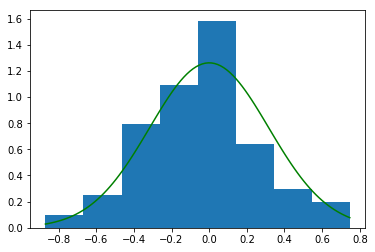

In [2]:
### Simulating Newcomb's astronomical observations ###
epsilon = 0.05 
#For each observation there is a 5% chance it will originate from a higher-variance Gaussian distribution
data100 = []
for j in range(100):
    if np.random.binomial(1,epsilon):
        data100.append(np.random.normal(0,5*10**(-1/2)))
    else:
        data100.append(np.random.normal(0,10**(-1/2)))
plt.clf()
plt.hist(data100,density=True,bins=8)
x = np.linspace(min(data100),max(data100),100)
plt.plot(x,ss.norm.pdf(x,0,1/np.sqrt(10)),color='green',label='Idealized measurements')

In [3]:
ss.shapiro(data100)
#With a sample size of 100 the contaminated data appear almost indistinguishable from truly Gaussian data

(0.9881523251533508, 0.5195064544677734)

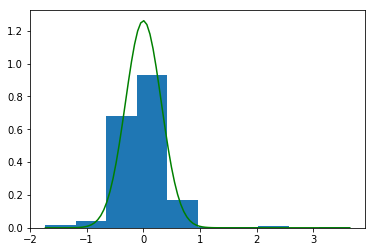

In [5]:
data500 = []
for j in range(500):
    if np.random.binomial(1,epsilon):
        data500.append(np.random.normal(0,5*10**(-1/2)))
    else:
        data500.append(np.random.normal(0,10**(-1/2)))
plt.clf()
plt.hist(data500,density=True,bins=10)
x = np.linspace(min(data500),max(data500),100)
plt.plot(x,ss.norm.pdf(x,0,1/np.sqrt(10)),color='green',label='Idealized measurements')


In [6]:
ss.shapiro(data500)
#With a larger sample data can be easily distinguished from Gaussian

(0.8585590124130249, 8.114820331523497e-21)

In [7]:
np.random.seed(123)

In [8]:
#Do X and Y appear independent?
P = np.array([[0.1,0.3],[0.1,0.5]])
data100 = np.random.multinomial(100,P.flatten())
ss.chi2_contingency(data100.reshape((2,2))) #With n=100 P still looks independent!

(2.9671109169515635, 0.08497348399462727, 1, array([[ 7.22, 30.78],
        [11.78, 50.22]]))

In [9]:
data500 = np.random.multinomial(500,P.flatten())
ss.chi2_contingency(data500.reshape((2,2))) 
#Still not particularly strong evidence against null hypothesis of independence, even with n=500!

(3.556970536241245, 0.0592958643677153, 1, array([[ 41.088, 150.912],
        [ 65.912, 242.088]]))

In [10]:
data1000 = np.random.multinomial(1000,P.flatten())
ss.chi2_contingency(data1000.reshape((2,2)))
#This seems like a very small p-value but may not be so significant with a multiple-hypothesis-test correction

(11.264995827170011, 0.0007898235789000834, 1, array([[ 74.108, 307.892],
        [119.892, 498.108]]))

In [11]:
#Let's put a 1% grid over the independent distributions on {0,1}^2
p_x = np.linspace(0,1,100)
p_y = np.linspace(0,1,100)
Lambda = 0.0
Qprime = np.zeros((2,2))
for i in range(100):
    for j in range(100):
        Q = np.array([[(1-p_x[i])*(1-p_y[j]),p_x[i]*(1-p_y[j])],[(1-p_x[i])*p_y[j],p_x[i]*p_y[j]]])
        #Create the independent source Q with marginals p_x and p_y for each combination of p_x and p_y
        if min((P/Q)[np.nonzero(Q)])>Lambda:
            Lambda = min((P/Q)[np.nonzero(Q)])
            #Compute the latent weight of the singleton {Q} in P, take the largest
            Qprime = Q

/home/antony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/antony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [12]:
Lambda

0.9522930431403029

In [13]:
import binary_alphabet_independent_weight as iw
import os

samples = os.listdir('./TFBSData/')
data = []
for j in range(len(samples)):
    f = open('./TFBSData/'+samples[j],'r')
    data.append(f.readlines())
    f.close()                      #Reading in k-mers for various transcription factors

purPyrBinData = []
for j in range(len(data)):
    purPyrBinData.append(iw.DNASeq2Phat(data[j])) #For each transcription factor, say data are length d strings
                                                    #gives the empirical distribution over {purine,pyrimidine}^d
    

short_targets = [x for x in purPyrBinData if 4<len(x)<=32] #Look only at 3,4 and 5-mers (computational efficiency)
short_target_indices = [i for i in range(len(purPyrBinData)) if 4<len(purPyrBinData[i])<=32]

In [14]:
for P in short_targets:
    print(iw.numerical_ind_weight(P)) #compute independent weight & associated marginal probs for each short TFBS

(array([0.81886024]), [1.0, 0.014705882354015766, 0.0, 0.9436619718308022])
(array([0.75605536]), [0.26086956521739135, 0.10526315789473681, 0.0, 1.0, 0.0])
(array([1.]), [0.0, 0.0, 0.0, 0.0, 0.8750000000000001])
(array([0.83568678]), [0.3870967741935477, 0.09523809523809444, 0.0, 1.0, 0.0])
(array([1.]), [0.0, 0.0, 0.0, 0.0, 0.8])
(array([1.]), [1.0, 0.0, 0.0, 1.0, 0.0])
(array([0.66895369]), [0.15384615384858555, 0.0, 0.0, 1.0, 0.26666666666641964])
(array([0.99521531]), [0.6875000000008926, 0.15384615384608724, 0.0, 1.0, 0.0])
(array([0.98305085]), [0.034482758620725106, 0.0, 1.0, 1.0, 0.0])


In [ ]:
#Approximate the i.i.d. weight of each TFBS by making a grid over P({A,C,G,T})

import simplex_grid as sg
import iid_weight as iid

def numerical_iid_weight(P,d): #Approximate the i.i.d. weight using a 4%-grid over the i.i.d. distributions
    k = 4
    qs = sg.simplex_grid(k,20)/20.
    Lambda = 0.0
    Qprime = np.zeros(np.shape(P))
    for j in range(len(qs)):
        Q = iid.create_iid_source(qs[i],d)
        if min((P/Q)[np.nonzero(Q)]):
            Lambda = min((P/Q)[np.nonzero(Q)])
            Qprime = Q
    return Lambda

'''samples = os.listdir('./TFBSData/')
data = []
for j in range(len(samples)):
    f = open('./TFBSData/'+samples[j],'r')
    data.append(f.readlines())
    f.close()        

empirical_dists,five_mer_indices = iid.k_less_than_five_mers2empirical_dist(data) '''

In [ ]:
'''TFBS_iid_weights = []
for P in empirical_dists:
    TFBS_iid_weights.append(numerical_iid_weight(P,int(np.log(len(P))/np.log(4))))'''

In [ ]:
for P in purPyrBinData:
    print(iid.iid_weight(P)[0]) #i.i.d. weights for TFBS where purines and pyrimidines are lumped

In [ ]:
import poisson_weight as pois
#Bortkiewicz's horse kick data
horse_kick_deaths = np.array([144,91,32,11,2])
mean = (0*144+1*91+2*32+3*11+4*2)/sum(horse_kick_deaths)
expected = sum(horse_kick_deaths)*np.exp(-mean)*np.array([mean**0,mean**1/np.math.factorial(1),mean**2/np.math.factorial(2),\
                                  mean**3/np.math.factorial(3),mean**4/np.math.factorial(4)])
ss.chisquare(horse_kick_deaths,expected)
#These data look consistent with a Poisson distribution with rate 0.7

In [ ]:
P = horse_kick_deaths/sum(horse_kick_deaths)
print(pois.poisson_weight(P))
#Indeed, almost all observations can be attributed to a Poisson(0.63) distribution 

In [ ]:
resampled_horse_kicks = np.random.multinomial(5000,P)
resampled_P = resampled_horse_kicks/sum(resampled_horse_kicks)
resampled_mean = np.dot(resampled_horse_kicks,[0,1,2,3,4])/sum(resampled_horse_kicks)
resampled_expected = sum(resampled_horse_kicks)*np.exp(-resampled_mean)*np.array([1,resampled_mean,\
                                            resampled_mean**2/2,resampled_mean**3/6,resampled_mean**4/24])
ss.chisquare(resampled_horse_kicks,resampled_expected)
#With a larger sample size this no longer appears Poisson under a GOF test

In [ ]:
print(pois.poisson_weight(resampled_P))
#But most data can still be attributed to a Poisson(0.62) distribution

In [ ]:
#Methylation data: How do we determine an adequate sample size? Looking at ``triplets'', Omega = {0,1}^3
#Let's build a coarse grid over the set of exchangeable distributions (why?) and find the sample size necessary
#for decently accurate estimation on the most pathological source

np.random.seed(999)

def exchangeable_weight(P):#Here, P is a source on {0,1}^3
    return P[0]+3*min([P[1],P[2],P[4]])+3*min([P[3],P[5],P[6]])+P[7]

E0 = np.array([1,0,0,0,0,0,0,0])
E1 = np.array([0,1/3,1/3,0,1/3,0,0,0])
E2 = np.array([0,0,0,1/3,0,1/3,1/3,0])
E3 = np.array([0,0,0,0,0,0,0,1]) #Each of these is a uniform measure over one equivalence class [x]
#When we form a mixture from them it will be exchangeable (all exchangeable distributions can be formed this way)
mix_weights = sg.simplex_grid(4,20)/20.

test_sources = []
for weight in mix_weights:
    test_sources.append(weight[0]*E0+weight[1]*E1+weight[2]*E2+weight[3]*E3)
    
#Is n=30 an adequate sample size?

bias = []
standard_error = []
estimates = []
for P in test_sources:
    estimate = []
    for k in range(100):
        Phat = np.random.multinomial(30,P)/30.
        estimate.append(exchangeable_weight(Phat))
    bias.append(np.mean(estimate)-1)
    standard_error.append(np.std(estimate))
    estimates.append(estimate)

In [ ]:
#Let's look at the worst case bias
print(test_sources[np.argmin(bias)])
plt.hist(estimates[np.argmin(bias)],bins=6,density=True)
plt.xlim(0,1)

In [ ]:
#Let's look at the worst case standard_error
print(test_sources[np.argmax(standard_error)])
plt.hist(estimates[np.argmax(standard_error)],density=True,bins=6)
plt.xlim(0,1)
#We expect the estimates to be close to 1 with high probability. This is clearly not a large enough n.

In [ ]:
#How about n=100?

bias = []
standard_error = []
estimates = []
for P in test_sources:
    estimate = []
    for k in range(100):
        Phat = np.random.multinomial(100,P)/100.
        estimate.append(exchangeable_weight(Phat))
    bias.append(np.mean(estimate)-1)
    standard_error.append(np.std(estimate))
    estimates.append(estimate)

In [ ]:
print(test_sources[np.argmin(bias)])
plt.hist(estimates[np.argmin(bias)],density=True,bins=6)
plt.xlim(0,1)

In [ ]:
print(test_sources[np.argmax(standard_error)])
plt.hist(estimates[np.argmax(standard_error)],density=True,bins=6)
plt.xlim(0,1)
#n=100 seems like a decent sample size but there are still several estimates close to 0.8 (want them close to 1).
#How about correcting the bias by resampling?

In [ ]:
#Take the worst-case-bias test source and correct its mean by Monte Carlo bootstrap-estimated bias
P = test_sources[np.argmin(bias)]
BS_corrected_estimates = []
Lambdas = []
BS_lambdas = []
for k in range(100):
    Phat = np.random.multinomial(100,P)/100.
    Lambda = exchangeable_weight(Phat)
    Lambdas.append(Lambda)
    BS_estimates = []
    for j in range(1000):
        Phat_star = np.random.multinomial(100,Phat)/100.
        BS_estimates.append(exchangeable_weight(Phat_star))
    BS_lambdas.append(BS_estimates)

corrected_lambdas = []
for j in range(100):
    corrected_lambdas.append(2*Lambdas[j]-np.mean(BS_lambdas[j]))
plt.hist(Lambdas,density=True,bins=6,alpha=0.5,color='red',label=r'Uncorrected $\hat\lambda_{100}$')
plt.hist(corrected_lambdas,density=True,bins=6,alpha=0.5,color='green',label=r'BS-corrected $\hat\lambda_{100}$')
plt.legend(loc='upper left')
plt.xlim(0,1)

In [ ]:
#Let's see if a randomly selected source can have its exchangeable weight estimated accurately:
P = np.random.dirichlet([1]*8)#Choosing a source uniformly at random from P({0,1}^3)
Lambda = exchangeable_weight(P)
Lambda_hats = []
for j in range(100):
    Phat = np.random.multinomial(100,P)/100.
    Lambda_hat = exchangeable_weight(Phat)
    resampled_lambdas = []
    for j in range(1000):
        Phat_star = np.random.multinomial(100,Phat)/100.
        Lambda_star = exchangeable_weight(Phat_star)
        resampled_lambdas.append(Lambda_star)
    Lambda_hats.append(2*Lambda_hat-np.mean(resampled_lambdas))
plt.xlim(0,1)
plt.hist(Lambda_hats,density=True)
plt.axvline(Lambda,color='red',linestyle='dashed')